In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
from scipy.spatial import distance

In [2]:
pubs_author_funder = pd.read_csv("..//..//..//data//Data//DerivedData//CleanedRawData//pubs_author_funder.csv")
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(
    lambda x: literal_eval(x) if pd.notnull(x) else x)

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
discode=pd.read_csv("..//..//..//data//Data/RawData//discipline_code.csv")
discode = discode.set_index('Code_Discipline')['ESpecialite'].to_dict()

In [4]:
pubs_author_funder=pubs_author_funder.replace({'discipline':discode})
pubs_author_funder.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],Computers,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",Mechanical Engineering,2009,0.703,9
2,30574691,[Russia],[Russia],Mechanical Engineering,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",General Mathematics,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],General Mathematics,2009,0.410,3


In [5]:
dis_total = pubs_author_funder.groupby('discipline').size()
dis_total.columns=['count']

In [6]:
world_total = pubs_author_funder.shape[0]
world_total

12759128

In [7]:
pubs_author_funder['author_distinct']=pubs_author_funder['author_country'].apply(
    lambda x:list(set(x)))
pubs_author_funder.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct
0,30507292,[Turkey],[Turkey],Computers,2009,0.485,6,[Turkey]
1,30574690,"[United States, France]","[United States, United States, United States, ...",Mechanical Engineering,2009,0.703,9,"[France, United States]"
2,30574691,[Russia],[Russia],Mechanical Engineering,2009,0.312,4,[Russia]
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",General Mathematics,2009,0.137,1,[Spain]
4,30585097,"[Germany, Spain]",[Spain],General Mathematics,2009,0.410,3,"[Germany, Spain]"


In [8]:
cntry_pub=pubs_author_funder.explode('author_distinct')

In [9]:
cntry_dis=cntry_pub.groupby(['author_distinct','discipline']).size().reset_index()
cntry_dis.columns=['cntry','dis','count']
cntry_dis = cntry_dis.pivot(index='cntry',columns='dis',values='count')
cntry_dis=cntry_dis.fillna(0)
cntry_dis.head()

dis,Acoustics,Addictive Diseases,Aerospace Technology,Agricult & Food Science,Allergy,Analytical Chemistry,Anatomy & Morphology,Anesthesiology,Applied Chemistry,Applied Mathematics,...,Probability & Statistics,Psychiatry,Radiology & Nuclear Medicine,Respiratory System,Solid State Physics,Surgery,Tropical Medicine,Urology,Veterinary Medicine,Virology
cntry,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,8.0,0.0,24.0,0.0,0.0,0.0,3.0,1.0,0.0,...,1.0,0.0,6.0,3.0,0.0,30.0,30.0,2.0,18.0,5.0
Albania,0.0,6.0,1.0,64.0,6.0,8.0,0.0,1.0,0.0,10.0,...,4.0,14.0,5.0,9.0,0.0,39.0,5.0,4.0,24.0,14.0
Algeria,64.0,0.0,65.0,748.0,26.0,142.0,0.0,3.0,75.0,752.0,...,221.0,6.0,66.0,24.0,403.0,24.0,52.0,17.0,176.0,12.0
Andorra,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0
Angola,0.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,5.0,0.0,3.0,56.0,0.0,2.0,3.0


In [10]:
cntry_total = cntry_dis.sum(axis=1)
cntry_total.columns=['count']
cntry_total.head()

cntry
Afghanistan      399.0
Albania         1424.0
Algeria        25049.0
Andorra           69.0
Angola           482.0
dtype: float64

In [11]:
def cal_rca(data,cntry_total, dis_total,world_total):
    cntrylist=cntry_total.index.tolist()
    dislist=dis_total.index.tolist()
    rca_df=pd.DataFrame(0,index=cntrylist,columns=dislist)
    for cntry,dis in product(cntrylist,dislist):
        cntry_dis=data.loc[cntry,dis]
        cntry_t=cntry_total.loc[cntry]
        dis_t=dis_total.loc[dis]
        value=(cntry_dis/cntry_t)*(world_total/dis_t)
        rca_df.loc[cntry,dis]=value
    return rca_df

In [12]:
pub_rca=cal_rca(cntry_dis,cntry_total,dis_total,world_total)

In [13]:
pubs_filter=pubs_author_funder[pubs_author_funder.funder_country.notna()]
pubs_filter['funder_distinct']=pubs_filter['funder_country'].apply(lambda x:list(set(x)))

<ipython-input-13-4a9237eb5727>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pubs_filter['funder_distinct']=pubs_filter['funder_country'].apply(lambda x:list(set(x)))


In [14]:
fund_total=pubs_filter.shape[0]
fund_dis_total=pubs_filter.groupby('discipline').size()

In [15]:
fund_cntry_dis = pubs_filter.explode("funder_distinct").groupby(
    ['funder_distinct','discipline']).size().reset_index()
fund_cntry_dis.columns=['cntry','dis','count']
fund_cntry_dis=fund_cntry_dis.pivot(index='cntry',columns='dis',values='count')
fund_cntry_dis=fund_cntry_dis.fillna(0)
fund_cntry_total=fund_cntry_dis.sum(axis=1)

In [16]:
fund_rca=cal_rca(fund_cntry_dis,fund_cntry_total,fund_dis_total,fund_total)

In [17]:
fund_rca[fund_rca>=1]=1
fund_rca[fund_rca<1]=0

In [18]:
pub_rca[pub_rca>=1]=1
pub_rca[pub_rca<1]=0

In [19]:
def Diff(a,b):
    n=0
    for i,m in zip(a,b):
        if i!=m:
            n=n+1
    return n


In [20]:
cntryset=list(set(pub_rca.index)&set(fund_rca.index))
resultlist=[]
for cntry in cntryset:
    pub_value=pub_rca.loc[cntry].values
    fund_value=fund_rca.loc[cntry].values
    dissim=Diff(pub_value,fund_value)
    resultlist.append([cntry,dissim])

In [21]:
dissim_df = pd.DataFrame(resultlist,columns=['cntry','dissimilarity'])
dissim_df.sort_values(by='dissimilarity')

,cntry,dissimilarity
45,Russia,3
93,Malaysia,3
40,China,5
22,Ukraine,5
185,Thailand,6
...,...,...
69,Liechtenstein,37
4,Lebanon,37
88,Dominican Republic,38
166,Republic of Kosovo,41


In [24]:
dissim_df.sort_values(by='dissimilarity',ascending=False)

,cntry,dissimilarity
118,Malta,44
166,Republic of Kosovo,41
88,Dominican Republic,38
69,Liechtenstein,37
4,Lebanon,37
...,...,...
28,Equatorial Guinea,6
22,Ukraine,5
40,China,5
93,Malaysia,3


In [25]:
import geopandas as gp
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys

In [26]:
flag_table = pd.read_csv("country_WoS_ECI_WB_flags.tsv", sep="\t")
world_geo = gp.read_file("ne_50m_admin_0_countries.shp")[
    ['NAME', "ISO_A3", "geometry", "ADM0_A3", 'CONTINENT', 'SUBREGION']]

gini_merge = dissim_df.merge(right=flag_table, left_on="cntry", right_on="WoS")
gini_merge = gini_merge.merge(
    how="inner", right=world_geo, left_on="Code", right_on="ADM0_A3")

gini_merge = gini_merge[gini_merge.CONTINENT != "Antarctica"]
#gini_merge['DIVERSITY'] = 1-gini_merge['GINI']
world_geo = world_geo[world_geo.CONTINENT != "Antarctica"]
gini_geo = gp.GeoDataFrame(gini_merge)

data_empty = world_geo[~(world_geo['ADM0_A3'].isin(gini_geo['ADM0_A3']))]


In [27]:
def plot_worldmap(ax, fig, basemap, data_empty, data, plotcolumn, cmap, vmax=1):
    """plot a basemap and color the country based on the column passed into
    """

    basemap.plot(ax=ax, linewidth=0.25, edgecolor='#8C8C8C', facecolor="#ffffff")
    data_empty.plot(ax=ax, linewidth=0.25, facecolor="#c4c0c0")
    data.plot(column=plotcolumn, cmap=cmap, vmin=0, vmax=vmax, ax=ax)
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cax)
    return fig, ax

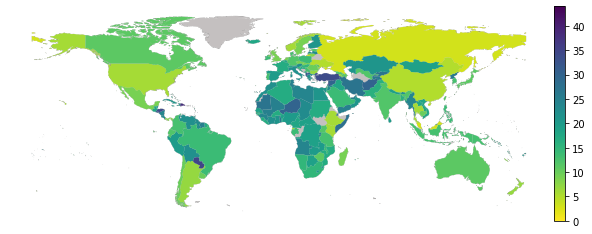

In [30]:
fig, ax = plt.subplots(1, figsize=(10, 6))
fig, ax = plot_worldmap(ax, fig, world_geo, data_empty, gini_geo, "dissimilarity", cmap="viridis_r",vmax=44)
plt.savefig("worldmap.pdf",format="pdf")

In [62]:
#the number of publication each country published in every discipline
cntry_dis.head()

dis,Acoustics,Addictive Diseases,Aerospace Technology,Agricult & Food Science,Allergy,Analytical Chemistry,Anatomy & Morphology,Anesthesiology,Applied Chemistry,Applied Mathematics,...,Probability & Statistics,Psychiatry,Radiology & Nuclear Medicine,Respiratory System,Solid State Physics,Surgery,Tropical Medicine,Urology,Veterinary Medicine,Virology
cntry,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,8.0,0.0,24.0,0.0,0.0,0.0,3.0,1.0,0.0,...,1.0,0.0,6.0,3.0,0.0,30.0,30.0,2.0,18.0,5.0
Albania,0.0,6.0,1.0,64.0,6.0,8.0,0.0,1.0,0.0,10.0,...,4.0,14.0,5.0,9.0,0.0,39.0,5.0,4.0,24.0,14.0
Algeria,64.0,0.0,65.0,748.0,26.0,142.0,0.0,3.0,75.0,752.0,...,221.0,6.0,66.0,24.0,403.0,24.0,52.0,17.0,176.0,12.0
Andorra,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0
Angola,0.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,5.0,0.0,3.0,56.0,0.0,2.0,3.0


In [31]:
funded_author = pubs_filter.explode("author_distinct")
funded_author=funded_author.explode('funder_distinct')
funded_author.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct
0,30507292,[Turkey],[Turkey],Computers,2009,0.485,6,Turkey,Turkey
1,30574690,"[United States, France]","[United States, United States, United States, ...",Mechanical Engineering,2009,0.703,9,France,United States
1,30574690,"[United States, France]","[United States, United States, United States, ...",Mechanical Engineering,2009,0.703,9,United States,United States
2,30574691,[Russia],[Russia],Mechanical Engineering,2009,0.312,4,Russia,Russia
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",General Mathematics,2009,0.137,1,Spain,Spain


In [32]:
funded_author = funded_author[funded_author.author_distinct==funded_author.funder_distinct]

In [121]:
fund_cntry_dis.head()

dis,Acoustics,Addictive Diseases,Aerospace Technology,Agricult & Food Science,Allergy,Analytical Chemistry,Anatomy & Morphology,Anesthesiology,Applied Chemistry,Applied Mathematics,...,Probability & Statistics,Psychiatry,Radiology & Nuclear Medicine,Respiratory System,Solid State Physics,Surgery,Tropical Medicine,Urology,Veterinary Medicine,Virology
cntry,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Albania,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,6.0,0.0,0.0,116.0,2.0,12.0,0.0,0.0,11.0,28.0,...,12.0,0.0,1.0,1.0,41.0,0.0,7.0,0.0,6.0,0.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0


In [34]:
fa_cntry_dis=funded_author.groupby(['author_distinct','discipline']).size().reset_index()
fa_cntry_dis.columns=['cntry','discipline','count']
fa_cntry_dis = fa_cntry_dis.pivot(index='cntry',columns='discipline',values='count')
fa_cntry_dis=fa_cntry_dis.fillna(0)
fa_cntry_dis.head()

discipline,Acoustics,Addictive Diseases,Aerospace Technology,Agricult & Food Science,Allergy,Analytical Chemistry,Anatomy & Morphology,Anesthesiology,Applied Chemistry,Applied Mathematics,...,Probability & Statistics,Psychiatry,Radiology & Nuclear Medicine,Respiratory System,Solid State Physics,Surgery,Tropical Medicine,Urology,Veterinary Medicine,Virology
cntry,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Albania,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,5.0,0.0,0.0,111.0,2.0,10.0,0.0,0.0,11.0,27.0,...,11.0,0.0,1.0,1.0,40.0,0.0,6.0,0.0,6.0,0.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0


In [66]:
def cal_rca_fa(data,cntry_total, dis_total,world_total):
    cntrylist=data.index.tolist()
    dislist=data.columns.tolist()
    #rca_df=pd.DataFrame(0,index=cntrylist,columns=dislist)
    rca_df=[]
    for cntry,dis in product(cntrylist,dislist):
        cntry_dis=data.loc[cntry,dis]
        cntry_t=cntry_total.loc[cntry,dis]
        #dis_t=dis_total.loc[dis]
        #world_t=world_total.loc[dis]
        value=(cntry_dis/cntry_t)
        #rca_df.loc[cntry,dis]=value
        rca_df.append([cntry,dis,value])
    for dis in dislist:
        dis_t=dis_total.loc[dis]
        world_t=world_total.loc[dis]
        rca_df.append(['world',dis,dis_t/world_t])
    rca_df=pd.DataFrame(rca_df, columns=['cntry','dis','value'])
    rca_df=rca_df.pivot(index="cntry",columns='dis',values='value')
    rca_df=rca_df.fillna(0)
    return rca_df

In [67]:
fa_rca=cal_rca_fa(fa_cntry_dis,cntry_dis,fund_dis_total,dis_total)
fa_rca.head()

<ipython-input-66-bdec9e0bfdc7>:11: RuntimeWarning: invalid value encountered in double_scalars
  value=(cntry_dis/cntry_t)


dis,Acoustics,Addictive Diseases,Aerospace Technology,Agricult & Food Science,Allergy,Analytical Chemistry,Anatomy & Morphology,Anesthesiology,Applied Chemistry,Applied Mathematics,...,Probability & Statistics,Psychiatry,Radiology & Nuclear Medicine,Respiratory System,Solid State Physics,Surgery,Tropical Medicine,Urology,Veterinary Medicine,Virology
cntry,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.055556,0.000000
Albania,0.000000,0.0,0.0,0.031250,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
Algeria,0.078125,0.0,0.0,0.148396,0.076923,0.070423,0.0,0.0,0.146667,0.035904,...,0.049774,0.0,0.015152,0.041667,0.099256,0.0,0.115385,0.0,0.034091,0.000000
Andorra,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
Angola,0.000000,0.0,0.0,0.083333,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.071429,0.0,0.500000,0.333333


In [70]:
fa_rca.tail(20)

dis,Acoustics,Addictive Diseases,Aerospace Technology,Agricult & Food Science,Allergy,Analytical Chemistry,Anatomy & Morphology,Anesthesiology,Applied Chemistry,Applied Mathematics,...,Probability & Statistics,Psychiatry,Radiology & Nuclear Medicine,Respiratory System,Solid State Physics,Surgery,Tropical Medicine,Urology,Veterinary Medicine,Virology
cntry,,,,,,,,,,,,,,,,,,,,,
Thailand,0.230769,0.229008,0.387755,0.605202,0.361111,0.710462,0.322917,0.363636,0.694444,0.633043,...,0.356436,0.150862,0.204878,0.159420,0.702259,0.161228,0.387884,0.282609,0.536193,0.560821
Togo,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tonga,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Trinidad and Tobago,0.000000,0.000000,0.000000,0.087500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.170732,0.000000,0.215686,0.181818
Tunisia,0.126316,0.500000,0.181818,0.286098,0.000000,0.206667,0.000000,0.000000,0.284810,0.059333,...,0.028986,0.031250,0.011561,0.017167,0.174950,0.007937,0.290000,0.037879,0.169312,0.336634
Turkey,0.299383,0.081301,0.242958,0.320975,0.119048,0.444010,0.055732,0.053375,0.485057,0.184089,...,0.114986,0.046786,0.065231,0.068579,0.483173,0.036539,0.163424,0.068345,0.194647,0.201970
Uganda,0.000000,0.050000,0.000000,0.070513,0.000000,0.111111,0.333333,0.105263,0.000000,0.033333,...,0.000000,0.007692,0.000000,0.029126,0.000000,0.073826,0.048212,0.111111,0.129630,0.024390
Ukraine,0.075472,0.187500,0.130435,0.036530,0.000000,0.160079,0.000000,0.000000,0.070175,0.071646,...,0.066667,0.051282,0.077922,0.076923,0.163964,0.019231,0.000000,0.111111,0.046512,0.000000
United Arab Emirates,0.085106,0.133333,0.033333,0.179487,0.062500,0.210526,0.040000,0.000000,0.136364,0.124224,...,0.127660,0.086420,0.075949,0.140845,0.155556,0.051064,0.000000,0.015385,0.042553,0.240000


In [61]:
c="United States"
d="General Biomedical Research"
fa_cntry_dis.loc[c,d]/cntry_dis.loc[c,d]

0.682837339625424

In [55]:
fa_cntry_dis.loc[c,d]

77944.0

In [59]:
fund_dis_total.loc[d]/dis_total.loc[d]

0.7603915618422985

In [78]:
cntry30 = cntry_total.sort_values(ascending=False).head(20).index
cntry30 = cntry30.insert(0,'world')

In [79]:
dis30 = dis_total.sort_values(ascending=False).head(20).index

In [80]:
fa_rca_30 = fa_rca.loc[cntry30,dis30]

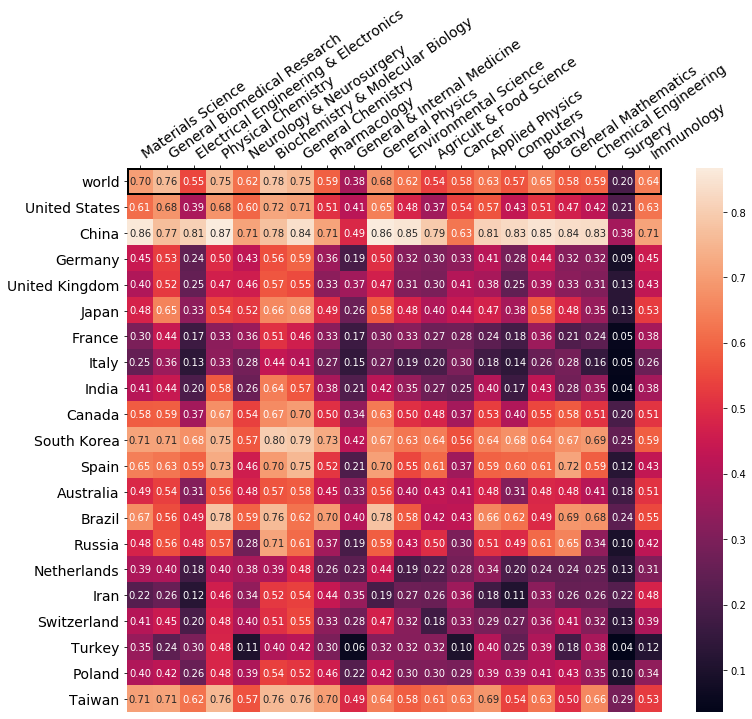

In [129]:
fig, ax=plt.subplots(figsize=(12,10))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

sns.heatmap(
    fa_rca_30.values, annot=True,
    fmt=".2f",xticklabels=dis30, yticklabels=cntry30)
ax.hlines(1,0,21,linewidth=2)
ax.hlines(0,0,21,linewidth=4)
ax.vlines(20,0,1,linewidth=4)
ax.vlines(0,0,1,linewidth=4)
plt.xticks(fontsize=14,rotation=35,horizontalalignment='left')
plt.yticks(fontsize=14)
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.savefig("fundpercentage.pdf",format="pdf",bbox_inches="tight")

In [83]:
fa_rca_30

discipline,Materials Science,General Biomedical Research,Electrical Engineering & Electronics,Physical Chemistry,Neurology & Neurosurgery,Biochemistry & Molecular Biology,General Chemistry,Pharmacology,General & Internal Medicine,General Physics,Environmental Science,Agricult & Food Science,Cancer,Applied Physics,Computers,Botany,General Mathematics,Chemical Engineering,Surgery,Immunology
cntry,,,,,,,,,,,,,,,,,,,,
world,0.701611,0.760392,0.546228,0.751797,0.617701,0.780460,0.754213,0.588494,0.379162,0.684825,0.622908,0.535204,0.578215,0.625924,0.569953,0.648651,0.583748,0.593404,0.195888,0.637365
United States,0.612836,0.682837,0.389256,0.684541,0.599612,0.720646,0.710488,0.508243,0.413092,0.645533,0.480415,0.369419,0.538460,0.568575,0.433332,0.510379,0.466072,0.424998,0.208574,0.625936
China,0.858139,0.769399,0.807618,0.866712,0.711563,0.775185,0.837736,0.713420,0.488820,0.863657,0.850719,0.793852,0.628379,0.808557,0.825011,0.847469,0.835053,0.831735,0.375876,0.712220
Germany,0.448169,0.531231,0.243681,0.496303,0.428787,0.559687,0.594630,0.363109,0.192261,0.502215,0.318148,0.301550,0.332841,0.414578,0.284628,0.442997,0.318007,0.321489,0.087065,0.454831
United Kingdom,0.398501,0.524382,0.251191,0.465994,0.458647,0.574208,0.553098,0.331566,0.370036,0.467547,0.310676,0.295681,0.405291,0.381743,0.246722,0.385133,0.326778,0.305772,0.129104,0.430809
Japan,0.475265,0.650421,0.332030,0.542116,0.522037,0.660193,0.677114,0.494204,0.264686,0.577507,0.475304,0.397443,0.439137,0.473254,0.378116,0.576884,0.484132,0.349487,0.128185,0.527340
France,0.296444,0.443084,0.172711,0.331321,0.355511,0.507682,0.461724,0.327577,0.167510,0.301519,0.325000,0.271233,0.276262,0.236784,0.182553,0.358316,0.209394,0.237113,0.049805,0.379092
Italy,0.252939,0.358620,0.133967,0.332615,0.280495,0.436316,0.409461,0.267400,0.148368,0.268568,0.190903,0.198406,0.296867,0.177979,0.138100,0.257385,0.283561,0.155519,0.045459,0.263991
India,0.411961,0.442986,0.203933,0.579295,0.264665,0.639771,0.574314,0.381206,0.212497,0.418529,0.348992,0.268104,0.254643,0.403414,0.167961,0.426458,0.278066,0.345037,0.038750,0.375022


In [118]:
test = pubs_filter.explode('funder_distinct')

In [120]:
test[test.funder_distinct=="Afghanistan"]

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct
620115,44220113,"[Afghanistan, Iran]",[Afghanistan],Veterinary Medicine,2010,0.000,0,"[Iran, Afghanistan]",Afghanistan
1528219,47174044,"[Bangladesh, Bangladesh, United States]","[United States, Afghanistan, India]",Environmental & Occupational Health,2011,0.000,0,"[Bangladesh, United States]",Afghanistan
2244705,49138219,"[United States, Switzerland]","[United States, Afghanistan, India]",Environmental & Occupational Health,2012,1.156,22,"[Switzerland, United States]",Afghanistan
4086092,53898034,"[Nepal, Nepal, India]","[Nepal, Australia, Norway, United Kingdom, Swi...",Meteorology & Atmospheric Science,2015,2.782,32,"[India, Nepal]",Afghanistan
4429954,54799017,"[China, Nepal]","[Nepal, Norway, Switzerland, Bhutan, Australia...",Geology,2015,1.344,11,"[China, Nepal]",Afghanistan
4769709,55662015,[Nepal],"[Nepal, Switzerland, Bhutan, Norway, United Ki...",Environmental Science,2015,1.699,18,[Nepal],Afghanistan
4772520,55671370,[Nepal],"[Nepal, Bhutan, Norway, United Kingdom, Switze...",Nutrition & Dietetic,2015,0.613,6,[Nepal],Afghanistan
4859035,55870630,"[Netherlands, Netherlands, United States, Nepal]","[Nepal, Bhutan, Norway, United Kingdom, Switze...",Oceanography & Limnology,2015,5.006,41,"[Nepal, United States, Netherlands]",Afghanistan
4926961,56022341,"[Nepal, Netherlands, Canada]","[Norway, Nepal, Bhutan, Switzerland, Australia...",Geology,2015,2.443,20,"[Netherlands, Canada, Nepal]",Afghanistan
5554066,57732614,"[Nepal, France, Netherlands, France, Bolivia, ...","[Nepal, Bhutan, EU, France, United Kingdom, Ba...",Geology,2016,4.749,26,"[France, Netherlands, Bolivia, Nepal]",Afghanistan
